## Das Jahr der Unruhe: Worüber wir berichtet haben, seit das Coronavirus die Schweiz erreichte

am 25.2.2020 wurde die erste Coronainfektion in der Schweiz nachgewiesen. Seither hat das Virus nicht nur die Infizierten im Griff, sondern sich tief in unser Leben gefressen. Das lässt sich auch daran ablesen, dass auf der Startseite der NZZ nur  wenige Themen gegen den (facettenreichen) Corona-Reigen eine Chance hatten: Lockdown und Schliessungen, ausfallende Sport- und Kulturveranstaltungen, finanzielle und psychische Belastung, die Toten, Testen und Tracen, Impfstoffe. 

Wie viel Raum diese Themen in den letzten 12 Monaten auf der Frontpage der NZZ hatten, zeichne ich in einer Visualisierung nach. 

**1. Kategorien von Suchworten, Stemming**

Ich beginne damit, häufig im Zusammenhang mit der Coronapandemie auftauchende Schlagworte zu Kategorien zusammenzufassen. Ziel ist es, einen Suchalgorithmus zu erstellen, der inahltsverwandte Artikel erkennt und richtig zuordnet. Damit dieser auch verschiedene morphologische Varianten eines Wortes erfasst, führen wir sowohl die Suchworte als auch die Worte der zu durchsuchenden Texte auf ihren gemeinsamen Wortstamm zurück. Dies geschieht mit einem sogenannten Stemmer. Hier verwende ich <a href=https://www.nltk.org/api/nltk.stem.html>Cistem</a>. Dieser Stemming-Algorithmus kann Deutsch und ist in NLTK bereits integriert.

In [1]:
categories = {
    'Testing': ['Massentests', 'Rückverfolgung', 'Testcenter', 'contact tracing', 'PCR', 'Schnelltest'],
    'Mutationen': ['Mutationen', 'britische Variante', 'B.1.1.7', 'mutieren'],
    'Krise': ['Coronakrise', 'Coronavirus-Krise', 'Pandemie'],
    'Lockdown': ['Lockdown', 'Shutdown'],
    'Massnahmen': ['Quarantäne', 'Massnahmen', 'Hygiene', 'Desinfektion', 'Abstand'],
    'Wuhan': ['Wuhan', 'Hubei', 'Wet Market', 'Wildtiermarkt'],
    'Impfen': ['Impfstoff', 'Impfstoffkandidat', 'impfen', 'Impfung'],
    'Homeoffice': ['Home-Office', 'Homeoffice','Home-Schooling', 'Homeschooling'],
    'Masken': ['Maskenpflicht', 'Masken', 'Mund-Nasen-Schutz'],
    'Aerosole': ['Tröpfchen', 'Aerosole', 'Superspreader'],
    'Tote': ['Coronatote', 'Triage', 'Intensivbett']
#    'Trump': ['Trump', 'US-Wahl', 'Präsidentschaftswahlen', 'Vorwahlen', 'Wahlmänner']
}
# Corona, Covid, Sars-CoV-2

In [2]:
import pandas as pd
from nltk.stem.cistem import Cistem
stemmer = Cistem()

In [3]:
# Stemmer-Anwendung ausprobieren:
lst_Tests = ['Massentests', 'Rückverfolgung', 'Testcenter', 'contact tracing', 'PCR', 'Schnelltest']
lst_stemmed = []
for word in lst_Tests:
    word_stemmed = stemmer.stem(word)
    lst_stemmed.append(word_stemmed)
lst_stemmed

['massentest',
 'ruckverfolgung',
 'testcent',
 'contact tracing',
 'pcr',
 'schnelltest']

In [4]:
# Aus den oben festgelegten Kategorien ein Dataframe mit Kategorie & Wortstamm des jeweiligen Suchwortes erstellen:
dfs = []
for key,values in categories.items():
    terms = []
    for term in values:                                  
        term_stemmed = stemmer.stem(term)               
        terms.append(term_stemmed)
    words =pd.DataFrame({'category': key, 'term': terms})
    dfs.append(words)

df_kategorien = pd.concat(dfs)
df_kategorien.head(10)

,category,term
0,Testing,massentest
1,Testing,ruckverfolgung
2,Testing,testcent
3,Testing,contact tracing
4,Testing,pcr
5,Testing,schnelltest
0,Mutationen,mutatio
1,Mutationen,britische varia
2,Mutationen,b.1.1.7
3,Mutationen,mutier


In [5]:
# Später müssen wir ganze Sätze stemmen mit removal von Stopwords, Satzzeichen und Zahlen.
# Dies geht so:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

string = 'Trumps Kampagne des maximalen Drucks gegen Iran ist gescheitert, nun braucht Amerika eine neue Strategie. Joe Biden sollte die verfehlte Iran-Politik seines Vorgängers korrigieren und rasch zum Atomabkommen zurückkehren. Erst dann gibt es die Chance, mit Teheran über eine Verlängerung des Abkommens und andere Streitfragen ins Gespräch zu kommen.'

tokens = nltk.word_tokenize(string)
stemmed = [stemmer.stem(w) for w in tokens if w not in stopwords.words('german') and w.isalpha()] 
stemmed    

['trump',
 'kampag',
 'maximal',
 'druck',
 'ira',
 'scheiter',
 'brauch',
 'amerika',
 'neu',
 'strategie',
 'joe',
 'bid',
 'verfehl',
 'vorgang',
 'korrigier',
 'rasch',
 'atomabkomm',
 'zuruckkehr',
 'erst',
 'gib',
 'chanc',
 'tehera',
 'verlangerung',
 'abkomm',
 'streitfrag',
 'sprach',
 'komm']

**2. Daten bereinigen, Stemming von Titel und Teaser**

Nach dem Scraping liegen über 7000 csvs vor, jeweils eines pro Capture der frontpage nzz.ch auf archive.org im untersuchten Zeitraum. Diese müssen nun zu einem einzigen zusammengeführt werden. Dieses df sollte ca. 7000 x 70 = 490 000 Einträge haben. Zusätzlich zu den bereits vorhandenen Spalten Titel, Teaser und URL wird eine für den Timestamp benötigt (diese bildet später die Zeitachse). Dies als neues DataFrame und als csv-Datei abspeichern. 

In [7]:
# Gesamter Datensatz aus ./csvs/*.csv
from os import listdir
from tqdm import tqdm

filepaths = [f for f in listdir("./csvs")]
columns = ['Titel', 'Teaser', 'url']
lst = []

for path in tqdm(filepaths):
    df = pd.read_csv(f'./csvs/{path}', usecols=columns)
    df['timestamp'] = path.split('.')[0]
    lst.append(df)

frame = pd.concat(lst, axis=0, ignore_index=True)

# Abspeichern als neues .csv:
frame.to_csv('frontpage_complete.csv')
frame.head()

100%|██████████| 7514/7514 [00:16<00:00, 460.69it/s]


,Titel,Teaser,url,timestamp
0,2019 war ein Jahr der Proteste. Eine...,"Ob in Chile, Hongkong, Frankreich, Liban...",www.nzz.ch/international/jahr-der-proteste-war...,20200101001752
1,"Von Chile bis Hongkong, von Januar b...","Millionen demonstrieren, Langzeitpräside...",www.nzz.ch/international/zehn-herausragende-er...,20200101001752
2,Der Beat der Proteste: Diese Musiker...,Die Chilenin Mon Laferte hat sich mit ih...,www.nzz.ch/feuilleton/lateinamerika-neue-prote...,20200101001752
3,"Feinstaub, Böllerverbote und das Feu...",In Zürich werden an Silvester wieder übe...,www.nzz.ch/zuerich/zuerich-silvesterzauber-das...,20200101001752
4,"«Ich weiss, wer den besten Käse hat»...",NaN,www.nzz.ch/schweiz/neujahrsansprachen-ich-weis...,20200101001752


Teaser und Lead fasse ich in der Spalte "search" zusammen (wobei die NaNs übersprungen werden und zugleich das Stemming stattfindet).

In [8]:
from nltk.corpus import stopwords
stopset = stopwords.words('german')
stopset.append('Nan')

In [9]:
def stemtitle(a, b):
    string = str(a) + ' ' + str(b)
    tokens = nltk.word_tokenize(string)
    stemmed = [stemmer.stem(w) for w in tokens if w not in stopset and w.isalpha()]
    s = ' '
    return s.join(stemmed)                           # gibt anstelle Liste einen String aus > besser für Suche

In [10]:
data = pd.read_csv('frontpage_complete.csv').fillna(value='')    # Entfernt NaNs vor dem Anwenden der Funktion

data['stemmed'] = data.apply(lambda row : stemtitle(row['Titel'], row['Teaser']), axis = 1) 
data['date'] = pd.to_datetime(data['timestamp'], format='%Y%m%d%H%M%S') # Konversion timestamp > Zeitformat
data.head()

,Unnamed: 0,Titel,Teaser,url,timestamp,stemmed,date
0,0,2019 war ein Jahr der Proteste. Eine...,"Ob in Chile, Hongkong, Frankreich, Liban...",www.nzz.ch/international/jahr-der-proteste-war...,20200101001752,jahr protest eine meinsam ideologie steck dahi...,2020-01-01 00:17:52
1,1,"Von Chile bis Hongkong, von Januar b...","Millionen demonstrieren, Langzeitpräside...",www.nzz.ch/international/zehn-herausragende-er...,20200101001752,von chil hongkong januar dezemb herausrag erei...,2020-01-01 00:17:52
2,2,Der Beat der Proteste: Diese Musiker...,Die Chilenin Mon Laferte hat sich mit ih...,www.nzz.ch/feuilleton/lateinamerika-neue-prote...,20200101001752,der beat protest dies musik stell lateinamerik...,2020-01-01 00:17:52
3,3,"Feinstaub, Böllerverbote und das Feu...",In Zürich werden an Silvester wieder übe...,www.nzz.ch/zuerich/zuerich-silvesterzauber-das...,20200101001752,feinstaub bollerverbot feuerwerk zeit klimastr...,2020-01-01 00:17:52
4,4,"«Ich weiss, wer den besten Käse hat»...",,www.nzz.ch/schweiz/neujahrsansprachen-ich-weis...,20200101001752,ich weiss wer bes kas diskr charm prasidential...,2020-01-01 00:17:52


**3. Einfache Suchfunktionen und Daten-Exploration**

Jetzt ist der Datensatz für verschiedene Suchalgorithmen vorbereitet. Wir beginnen die Exploration der Daten mit einfachen Zähl-Abfragen und Linienplots. Später wechseln wir auf eine komplexere Darstellung, bei der die Ergebnisse mehrerer Suchanfragen in einem Steamgraph visualisiert werden.

In [11]:
# Jetzt können wir mit str.contains('Suchwort') eine einfache Suchabfrage machen. ZB so:
import re
data['stemmed'].str.contains('Impf*', flags=re.IGNORECASE).value_counts()

False    537017
True      10740
Name: stemmed, dtype: int64

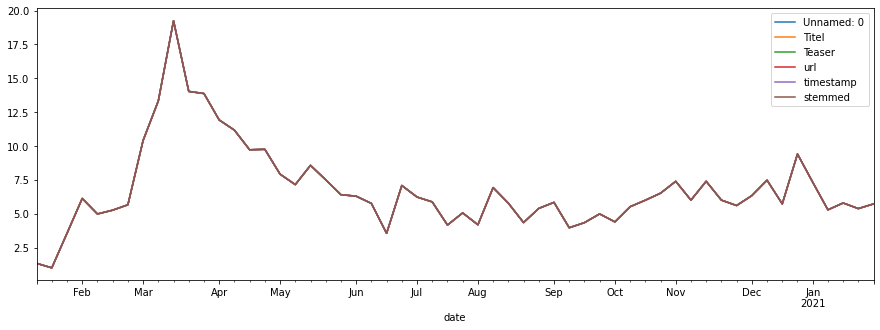

In [12]:
corona = data[data['stemmed'].str.contains('corona', flags=re.IGNORECASE) == True].groupby('date').count()
corona.resample('w').mean().plot(figsize=(15,5))

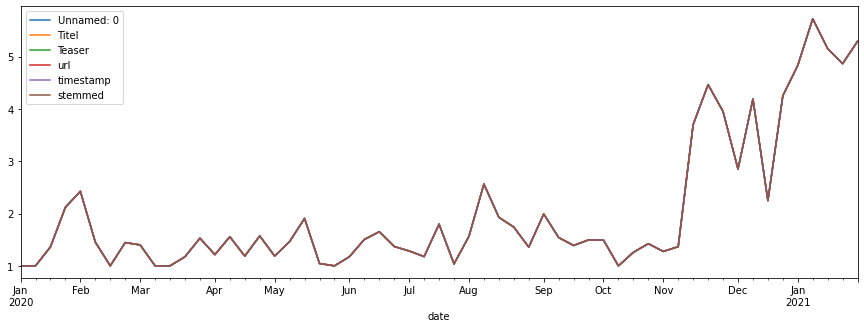

In [13]:
impfung = data[data['stemmed'].str.contains('impf*', flags=re.IGNORECASE) == True].groupby('date').count()
impfung.resample('w').mean().plot(figsize=(15,5))

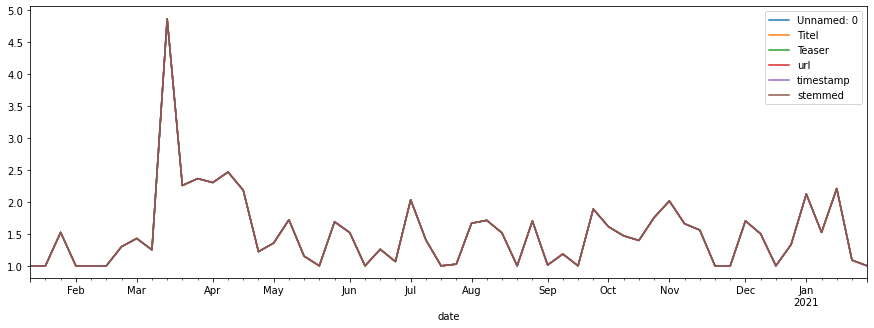

In [14]:
mass = data[data['stemmed'].str.contains('massnahm*', flags=re.IGNORECASE) == True].groupby('date').count()
mass.resample('w').mean().plot(figsize=(15,5))

Looking at krise*
Looking at impf*
Looking at massnahm*
Looking at maske*
Looking at trump


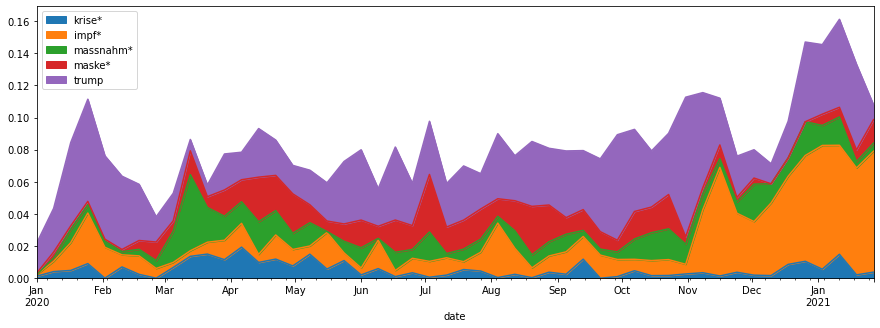

In [15]:
# Mehrere Suchanfragen im selben Plot:

schlagworte = ['krise*', 'impf*', 'massnahm*', 'maske*', 'trump']

# arbeiten mit verkürztem Datensatz
mydata = data[['stemmed', 'date']].copy()

for wort in schlagworte:
    print(f"Looking at {wort}")
    mydata[wort] = mydata['stemmed'].str.contains(wort, flags=re.IGNORECASE).astype(int) 
    
# resampling über 8 Tage (für späteres Interpolieren notwendig)
trends = mydata.resample('8D', on='date').mean()
# alle übereinander plotten
ax = trends.plot(kind='area', stacked=True, figsize=(15,5))

In [16]:
# Steamplot für multiple Suchanfragen
import matplotlib.pyplot as plt

def steamplot(lst):
    mydata = data[['stemmed', 'date']].copy()
    for wort in lst:
        print(f"Looking at {wort}")
        mydata[wort] = mydata['stemmed'].str.contains(wort, flags=re.IGNORECASE).astype(int) 
    # resample
    dtrends = mydata.resample('8D', on='date').mean()
    # smooth
    first = dtrends.index.min()
    last = dtrends.index.max()
    frequency = pd.date_range(start=first, end=last, freq='2D')
    dsmooth = dtrends.reindex(frequency).interpolate(method='quadratic')
    # display
    fig, ax = plt.subplots(figsize=(15,5))
    ax.stackplot(dsmooth.index, dsmooth.T, baseline='wiggle', labels=dsmooth.columns)
    ax.legend(loc=(1.04,0))

Looking at corona*
Looking at trump


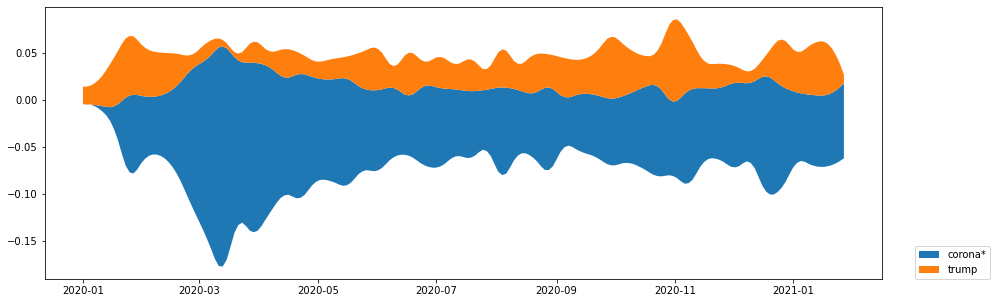

In [17]:
lst = ['corona*', 'trump']
steamplot(lst)
plt.savefig('trends1.svg', dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape')
plt.savefig('trends1.pdf', dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape')

Looking at krise*
Looking at impf*
Looking at massnahm*
Looking at pandemie
Looking at trump


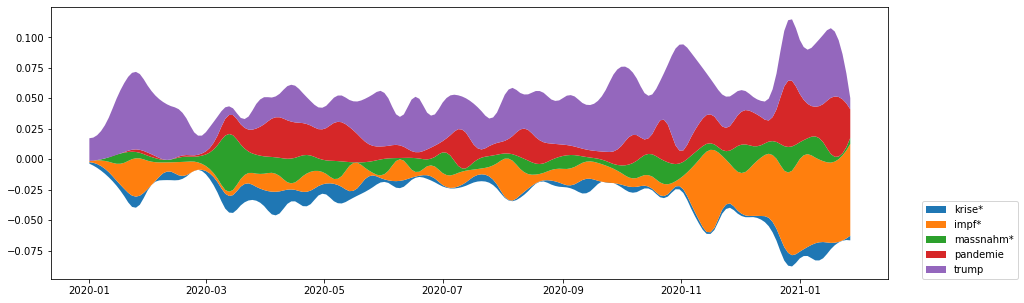

In [21]:
lst = ['krise*', 'impf*', 'massnahm*', 'pandemie', 'trump']
steamplot(lst)
plt.savefig('trends2.svg', dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape')
plt.savefig('trends2.pdf', dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape')

Looking at maske*
Looking at homeschooling
Looking at party
Looking at zoom
Looking at lockdown


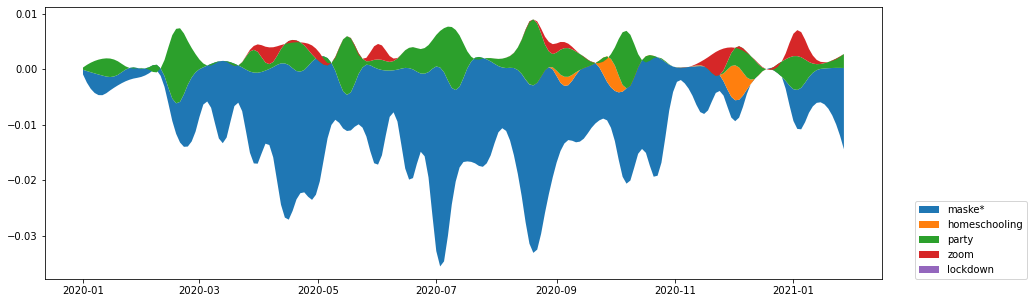

In [22]:
lst = ['maske*', 'homeschooling', 'party', 'zoom', 'lockdown']
steamplot(lst)
plt.savefig('trends3.svg', dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape')
plt.savefig('trends3.pdf', dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape')

**4. Komplexe Suchanfragen mit Suchwort-Kategorien:**

Oben habe ich das DataFrame "df_kategorien" definiert, das viele Schlagworte einer Handvoll griffiger Kategorien zuordnet. Nun möchte ich mit diesen experimentieren. Dazu erstelle ich wiederum eine Funktion, die wie oben verschiedene Suchworte durchgeht, diese aber gleich der richtigen Kateorie zuordnet. 

In [23]:
def superplot(search):  # search bezeichnet mehrere Dataframes mit zu Kategorien zugeordneten Suchworten
    # df_set erzegen
    dfs = []
    for key,values in search.items():
        terms = []
        for term in values:                                   
            term_stemmed = stemmer.stem(term)               
            terms.append(term_stemmed)
        words =pd.DataFrame({'category': key, 'term': terms})
        dfs.append(words)
    df_search = pd.concat(dfs)
    
    mydata = data[['stemmed', 'date']].copy()
    for category, rows in df_search.groupby('category'):
        terms = list(rows['term'])
        print(f'Suche nach {category} mit den Schlagworten {terms}')
        mydata[category] = mydata['stemmed'].apply(lambda x: 1 if any(i in x for i in terms) else 0)

    # resample
    ktrends = mydata.resample('8D', on='date').mean()
    # smooth
    first = ktrends.index.min()
    last = ktrends.index.max()
    frequency = pd.date_range(start=first, end=last, freq='2D')
    ksmooth = ktrends.reindex(frequency).interpolate(method='quadratic')
    # display
    fig, ax = plt.subplots(figsize=(15,5))
    ax.stackplot(ksmooth.index, ksmooth.T, baseline='wiggle', labels=ksmooth.columns)
    ax.legend(loc=(1.04,0))    

In [24]:
set1 = {
    'Krise': ['Coronakrise', 'Coronavirus-Krise', 'Pandemie'],
    'Lockdown': ['Lockdown', 'Shutdown'],
    'Impfen': ['Impfstoff', 'Impfstoffkandidat', 'impfen', 'Impfung'],
    'Massnahmen': ['Quarantäne', 'Massnahmen', 'Hygiene', 'Desinfektion', 'Abstand']
}

set2 = {
    'Mutationen': ['Mutationen', 'britische Variante', 'B.1.1.7', 'mutieren'],
    'Wuhan': ['Wuhan', 'Hubei', 'Wet Market', 'Wildtiermarkt'],
    'Tote': ['Coronatote', 'Triage', 'Intensivbett'],
    'Aerosole': ['Tröpfchen', 'Aerosole', 'Superspreader'],
    'Homeoffice': ['Home-Office', 'Homeoffice','Home-Schooling', 'Homeschooling'],
    'Masken': ['Maskenpflicht', 'Masken', 'Mund-Nasen-Schutz'],
    'Testing': ['Massentests', 'Rückverfolgung', 'Testcenter', 'contact tracing', 'PCR', 'Schnelltest']
}

set3 = {
    'Corona': ['Corona', 'Covid', 'Sars-CoV-2'],
    'Trump': ['Trump', 'US-Wahl', 'Präsidentschaftswahlen', 'Vorwahlen', 'Wahlmänner']
    
}

searches = [set1, set2, set3]

Suche nach Impfen mit den Schlagworten ['impfstoff', 'impfstoffkandidat', 'impf', 'impfung']
Suche nach Krise mit den Schlagworten ['coronakri', 'coronavirus-kri', 'pandemie']
Suche nach Lockdown mit den Schlagworten ['lockdow', 'shutdow']
Suche nach Massnahmen mit den Schlagworten ['quaranta', 'massnahm', 'hygie', 'desinfektio', 'absta']
Suche nach Aerosole mit den Schlagworten ['tropfch', 'aerosol', 'superspread']
Suche nach Homeoffice mit den Schlagworten ['home-offic', 'homeoffic', 'home-schooling', 'homeschooling']
Suche nach Masken mit den Schlagworten ['maskenpflicht', 'mask', 'mund-nasen-schutz']
Suche nach Mutationen mit den Schlagworten ['mutatio', 'britische varia', 'b.1.1.7', 'mutier']
Suche nach Testing mit den Schlagworten ['massentest', 'ruckverfolgung', 'testcent', 'contact tracing', 'pcr', 'schnelltest']
Suche nach Tote mit den Schlagworten ['coronatot', 'triag', 'intensivbett']
Suche nach Wuhan mit den Schlagworten ['wuha', 'hubei', 'wet market', 'wildtiermarkt']
Such

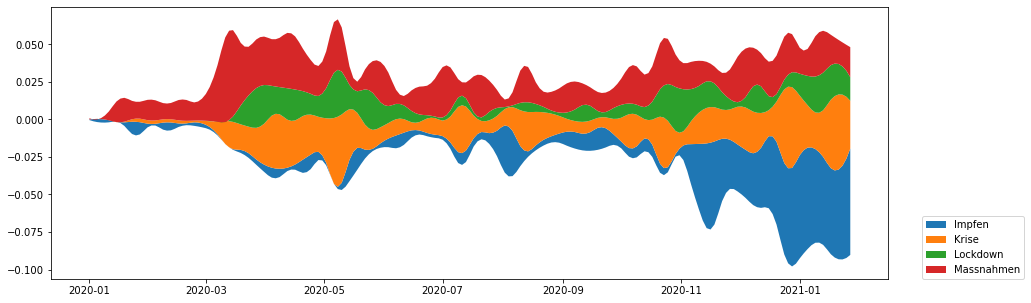

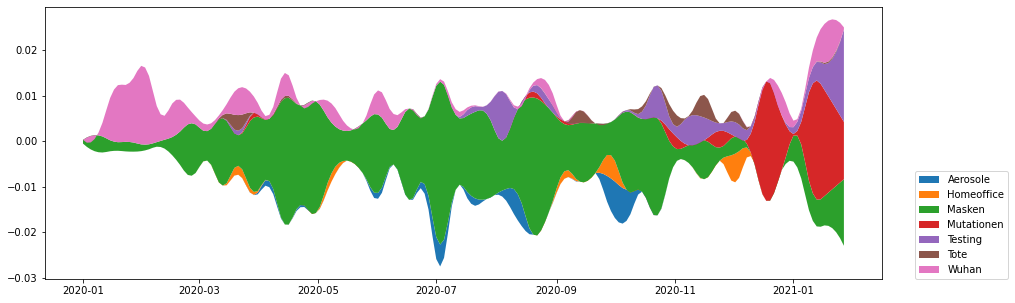

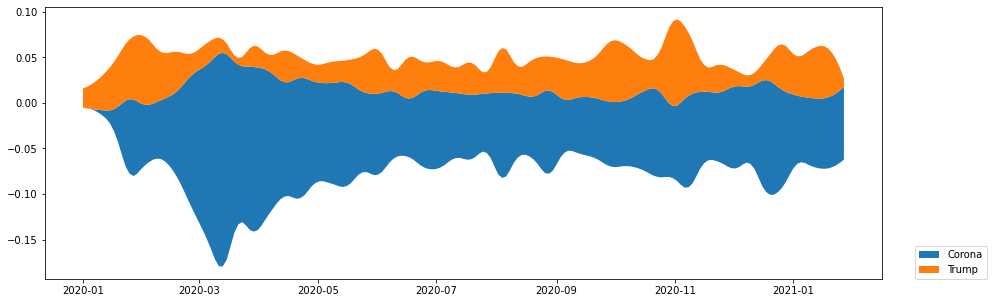

In [25]:
for x in searches:
    superplot(x)